In [1]:
import sys

sys.path.append("..")

import numpy as np

import tensorflow as tf

from utils import viz_utils, eeg_utils, fmri_utils, tf_config, process_utils, preprocess_data, train, losses_utils

from models import eeg_to_fmri, classifiers

from layers import fft

from sklearn import metrics

import matplotlib.pyplot as plt

tf_config.set_seed(seed=3)#02 20
tf_config.setup_tensorflow(device="GPU", memory_limit=1500)

path_labels="../../metrics/10_synth_01_style_prior_bayesian/"
view="fmri"

2022-04-05 15:21:53.359118: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-05 15:21:55.907549: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-05 15:21:55.908170: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-05 15:21:55.988107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 15:21:55.988661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-04-05 15:21:55.988689: I tensorflow/stream_executor/platform/def

In [2]:
views = np.load(path_labels+"views.npy", allow_pickle=True)
y_true = np.load(path_labels+"y_true.npy")
y_pred = np.load(path_labels+"y_pred.npy")

## Load patterns

In [26]:
class Pattern:
    
    def __init__(self, values, size, voxels, instances, pvalue, lifts):
        
        self.values=values
        self.size=size
        self.voxels=voxels
        self.instances=instances
        self.pvalue=pvalue
        self.lifts=lifts
        
    def mask(self, X, low=False, resolution=None):
        if(low):
            assert not resolution is None
        else:
            resolution=X.shape[1:-1]
        
        z = np.zeros((X.shape[0],)+resolution, dtype="float32")
        z = np.reshape(z, (X.shape[0], resolution[0]*resolution[1]*resolution[2]))
        z[self.instances,:]=1.
        z[:,self.voxels]*=-1.
        z[np.where(z==1.)]=0.0
        z[np.where(z==-1.)]=1.0
        
        if(low):
            z = np.reshape(z, (X.shape[0],)+resolution)
            z = np.expand_dims(fft.padded_iDCT3D(*resolution, *X.shape[1:-1])(fft.DCT3D(*resolution)(z)).numpy(), axis=-1)
            
        return (z-np.amin(z))/(np.amax(z)-np.amin(z))

class Bics_Patterns:
    
    def __init__(self, X, relu=None, low=True, resolution=(14,14,7)):
        self.patterns=[]
        self.X=X
        self.relu=relu
        self.low=low
        self.resolution=resolution
        
    def add(self, pattern):
        if(type(pattern) is dict):
            raise NotImplementedError  
        elif(type(pattern) is Pattern):
            self.patterns+=[pattern]
        else:
            print("E: Pattern structure not recognized.")
        
    def get(self, index):
        assert index < len(self.patterns)
        
        return self.patterns[index]
    
    def get_best(self):
        best_value=-1
        best_index=-1
        for pattern in range(len(self.patterns)):
            lifts=np.mean(self.get(pattern).lifts)
            if(lifts>best_value):
                best_value=lifts
                best_index=pattern
        return best_index
    
    
    def apply_mask(self, index):
        pattern=self.get(index)
        return pattern.mask(self.X, low=self.low, resolution=self.resolution)
        
    def apply_mask_relu(self, index):
        pattern=self.get(index)
        return pattern.mask(self.relu, low=self.low, resolution=self.resolution)
    
    @classmethod
    def build(self, f, X, **kwargs):
        patterns=Bics_Patterns(X, **kwargs)
        
        with open(f, "r") as f:
            lines = f.readlines()
        for line in lines:
            if(not "I=" in line):
                continue
            if("too small" in line):
                continue
            if("long" in line):
                continue

            line_list=line[1:-1].split(" ")
            values=np.array(line_list[0][3:-1].split(","), dtype="float32")#I
            size=(int(line_list[1][1:-1].split(",")[0]), int(line_list[1][1:-1].split(",")[1]))
            voxels=np.array(line_list[2][3:-1].split(","), dtype="int32")
            instances=np.array(line_list[3][3:-1].split(","), dtype="int32")
            pvalue=float(line_list[4].split("=")[1])
            class_lifts=np.array([float(line_list[5].split("=")[1][1:-1]),float(line_list[6][:-1])], dtype="float32")       
            patterns.add(Pattern(values,size,voxels,instances,pvalue,class_lifts))
            
        return patterns

In [37]:
patterns=Bics_Patterns.build("../../biclusters/view_bics_v1.txt", views, relu=relu_views, low=True, resolution=(14,14,7))
masked_data = patterns.apply_mask(patterns.get_best())

## Visualize Biclustering Patterns 

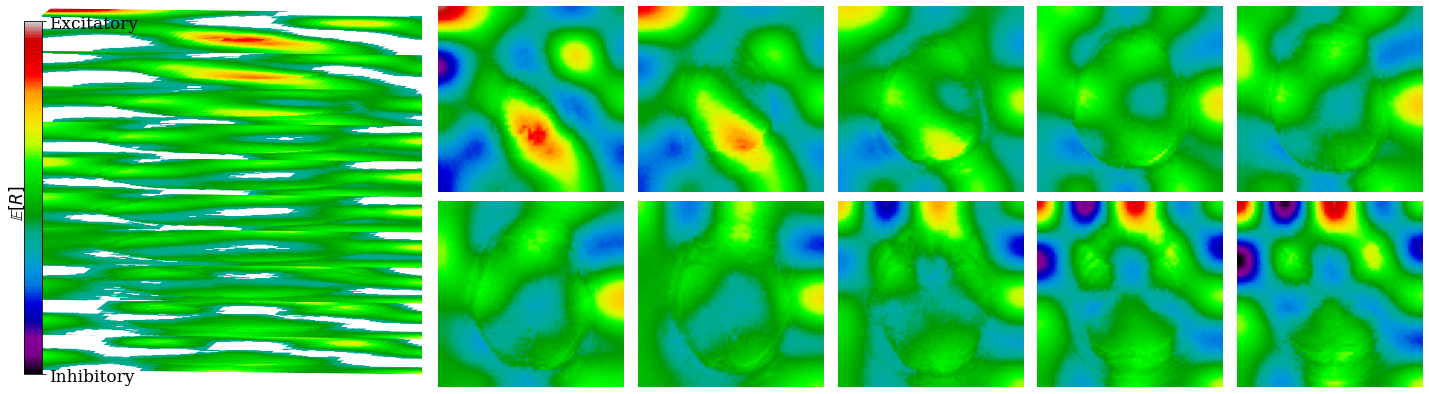

In [38]:
i=21
#21,25,29
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(views[i*8:i*8+8], axis=0),
                                                        res_img=np.mean(views[i*8:i*8+8],axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Inhibitory","Excitatory"])

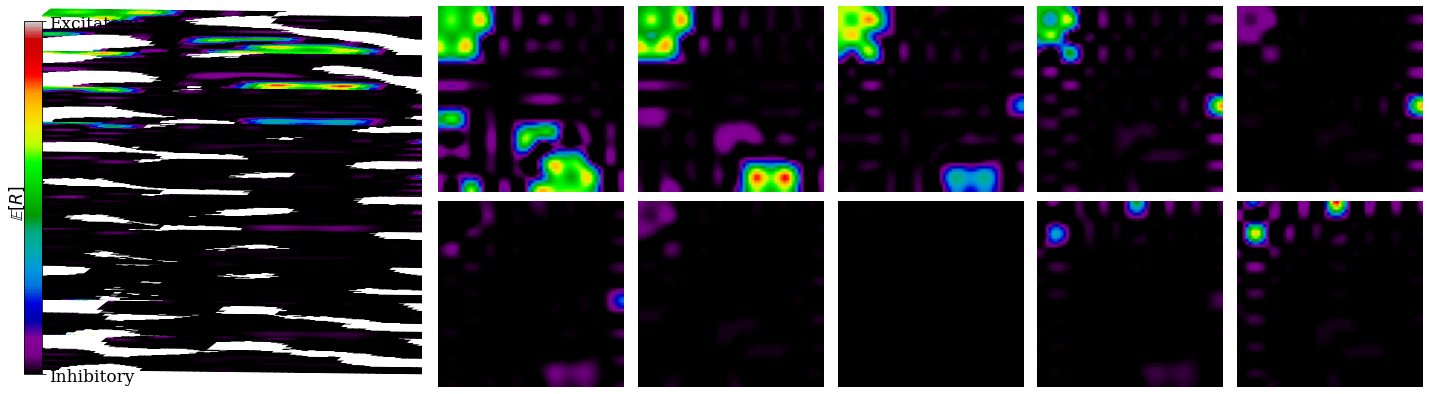

In [39]:
fig = viz_utils.plot_3D_representation_projected_slices(np.amax(masked_data[i*8:i*8+8], axis=0),
                                                        res_img=np.mean(views[i*8:i*8+8],axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Inhibitory","Excitatory"])

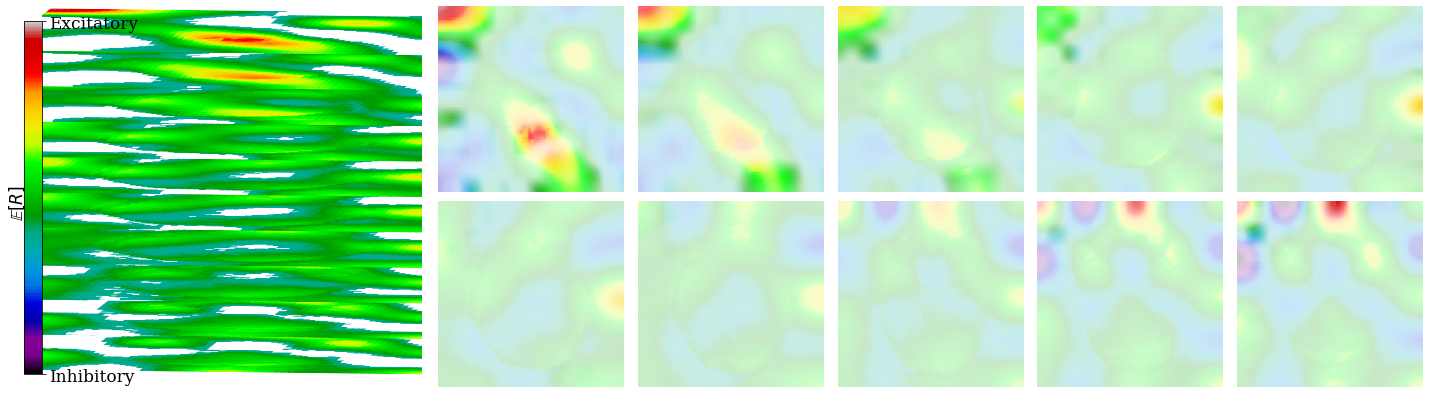

In [40]:
fig = viz_utils.plot_3D_representation_projected_slices_alpha(np.mean(views[i*8:i*8+8], axis=0),
                                                        res_img=np.mean(views[i*8:i*8+8],axis=0),
                                                        alpha_img=np.amax(masked_data[i*8:i*8+8], axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Inhibitory","Excitatory"])